## 01 - Data Selection
---

Our parent sample is a catalog of 22563 wide binaries consisting of one main sequence star and one white dwarf from El-Badry, et. al. For each system in this sample, we identify the white dwarf by it's position on the color magnitude diagram. Radial velocities for the main sequence companion of each wide binary are obtained from Gaia DR3. We restrict our dataset to those systems whose main sequence companion has been measured in Gaia to an error less than $2km/s$ and which Gaia does not flag as a spectroscopic binary. This latter cut ensures that the radial velocity measured by Gaia is not affected by the white dwarf companion. Additionally, we correct the sample for chance alignments by removing all wide binaries with ({\tt\string R\_chance\_align}) $\leq 0.1$ in the El-Badry, et. al. catalog, as recommended. 

Finally, after these cuts are applied, we discard those systems that do not have both photometry and spectroscopy in the Sloan Digital Sky Survey and those spectra are visually inspected and systems whose white dwarf companions are not DA are discarded. This results in 66 systems from SDSS-4, and XX systems from SDSS-5 measured via the focal plane system.  

In [1]:
import numpy as np
import sys
sys.path.append('../corv/src')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from tqdm import tqdm
import pandas as pd

from astropy.table import Table, vstack, join
from astropy import units as u
from astropy.coordinates import SkyCoord

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c
import data_selector as ds

In [2]:
"""
Load in the el-Badry dataset
"""

catalog = ds.get_catalog('data/catalog_sdss4.csv', build_spectra = False)
catalog = Table.from_pandas(catalog)
print(len(catalog))

22563


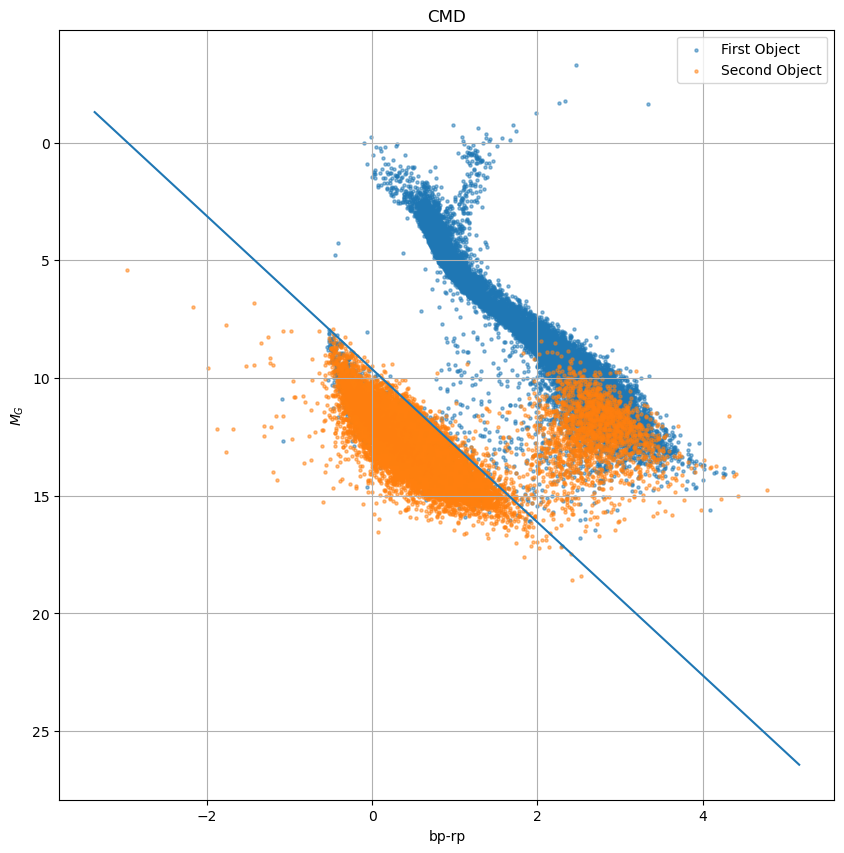

In [3]:
"""
Use the color-magnitude diagram to identify the white dwarf
"""

def wd_sep(bp_rp):
    return 3.25*bp_rp + 9.625

plt.figure(figsize=(10,10))

plt.scatter(catalog['bp_rp1'], catalog['phot_g_mean_mag1'] + 5 * (np.log10(catalog['parallax1'] / 100)), label='First Object', alpha = 0.5, s=5)
plt.scatter(catalog['bp_rp2'], catalog['phot_g_mean_mag2'] + 5 * (np.log10(catalog['parallax2'] / 100)), label='Second Object', alpha = 0.5, s=5)

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

plt.savefig('plots/selection/cmd.png')

plt.legend()
plt.show()

In [4]:
wd_obj = []
ms_obj = []
drop = []

for i in tqdm (range(len(catalog))):
    mg1 = wd_sep(catalog['bp_rp1'][i])
    mg2 = wd_sep(catalog['bp_rp2'][i])
    
    M1 = catalog['phot_g_mean_mag1'][i] + 5 * (np.log10(catalog['parallax1'][i] / 100))
    M2 = catalog['phot_g_mean_mag2'][i] + 5 * (np.log10(catalog['parallax2'][i] / 100))
    
    if M1 > mg1 and M2 < mg2:
        wd_obj.append(1)
        ms_obj.append(2)
    elif M2 > mg2 and M1 < mg1:
        wd_obj.append(2)
        ms_obj.append(1)
    else:
        drop.append(i)
               
catalog.remove_rows(drop)
catalog['wd_obj'] = wd_obj
catalog['ms_obj'] = ms_obj
#catalog.reset_index(inplace=True, drop=True)

100%|█████████████████████████████████| 22563/22563 [00:00<00:00, 138467.58it/s]


In [5]:
def separate(catalog, column, ms_obj, wd_obj, newname = ''):      
    mstemp_arr = [ catalog[str(column) + str(ms_obj[i])][i] for i in range(len(ms_obj)) ]
    wdtemp_arr = [ catalog[str(column) + str(wd_obj[i])][i] for i in range(len(wd_obj)) ]
    
    catalog['ms_' + str(column)] = mstemp_arr
    catalog['wd_' + str(column)] = wdtemp_arr
    return catalog

### ---

convert_cols = ['source_id', 'parallax', 'parallax_over_error', 'phot_g_mean_mag', 'phot_g_mean_flux',
                'phot_g_mean_flux_error', 'phot_bp_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
                'phot_rp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'bp_rp', 'ra', 'ra_error', 'dec', 'dec_error', 'l', 'b']

for col in convert_cols:
    catalog = separate(catalog, col, ms_obj, wd_obj)
    
catalog['wd_m_g'] = catalog['wd_phot_g_mean_mag'] + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['ms_m_g'] = catalog['ms_phot_g_mean_mag'] + 5 * np.log10(catalog['ms_parallax'] / 100)

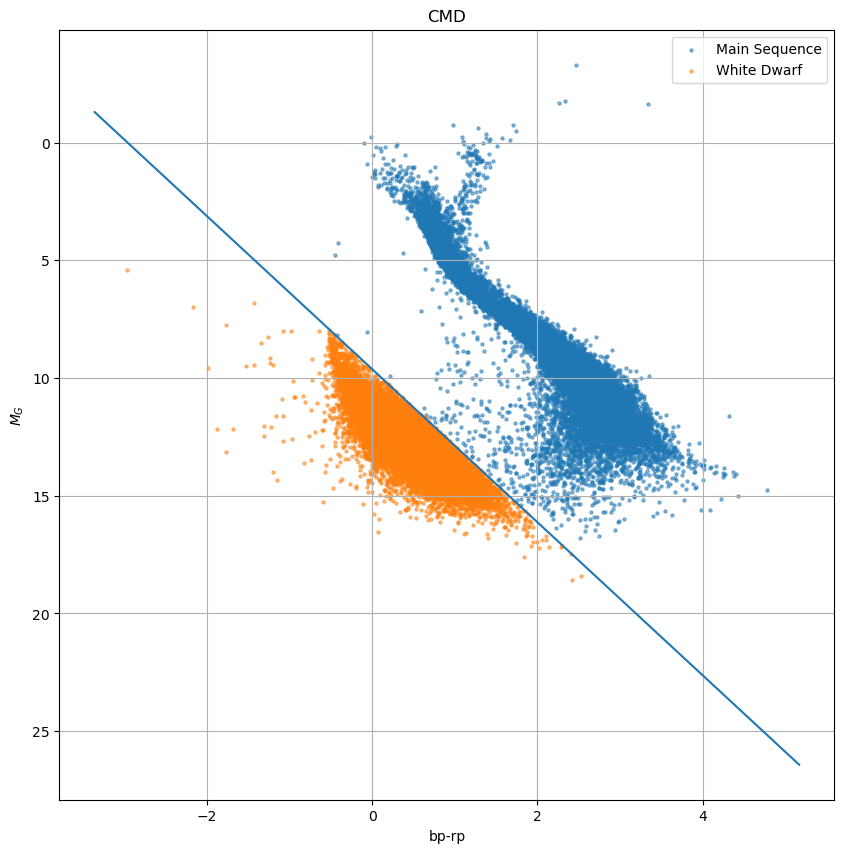

In [6]:
plt.figure(figsize=(10,10))

plt.scatter(catalog['ms_bp_rp'], catalog['ms_m_g'], label='Main Sequence', alpha = 0.5, s=5)
plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

plt.savefig('plots/selection/wd_ms_cmd.png')

plt.legend()
plt.show()

In [7]:
from astropy.table import Table, vstack, hstack

stardats = []
iters = len(catalog) // 100

for i in tqdm(range(iters)):
    ADQL_CODE1 = "SELECT source_id, radial_velocity, radial_velocity_error, non_single_star \
        FROM gaiadr3.gaia_source \
        WHERE gaia_source.source_id IN {}\
        AND radial_velocity is not null\
        AND radial_velocity_error < 2\
    ".format(tuple(catalog['ms_source_id'][100*i:100*i+100]))
    stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
    
d1 = vstack(stardats)

100%|█████████████████████████████████████████| 223/223 [02:47<00:00,  1.33it/s]


In [8]:
drops = []
rv = []
erv = []
nss = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(catalog['ms_source_id'][i] == d1['source_id'])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        rv.append(d1['radial_velocity'][j])
        erv.append(d1['radial_velocity_error'][j])
        nss.append(d1['non_single_star'][j])
    else:
        drops.append(i)   

catalog.remove_rows(drops)
catalog['ms_rv'] = rv
catalog['ms_erv'] = erv
catalog['ms_non_single_star'] = nss
#catalog.reset_index(inplace=True, drop=True)

100%|██████████████████████████████████| 22318/22318 [00:02<00:00, 10611.32it/s]


In [9]:
catalog = catalog[catalog['ms_non_single_star'] != 2]

print(len(catalog))

5207


In [10]:
print(catalog[['wd_source_id', 'wd_ra', 'wd_dec']])
df = catalog[['wd_source_id', 'wd_ra', 'wd_dec']]
df['name'] = df['wd_source_id']
df['ra'] = df['wd_ra']
df['dec'] = df['wd_dec']

df[['name', 'ra', 'dec']].write(r'data/wd_locs.txt', format='csv', overwrite=True)

    wd_source_id          wd_ra               wd_dec      
------------------- ------------------ -------------------
4282299551960647680 282.50739799835634   5.296428938204327
3124538851862773120  94.75751591827496  2.1788953664313686
3050837938914366592  104.4483638946952  -8.587649965172762
6129251625151149952  190.5039471746433  -46.01399021979076
 455517329408362752  35.29580680811094   53.55823924638252
 455168200100958336  33.01471397324092   52.39244505991806
 277090540953615616  68.32301890196736   55.45367816673778
                ...                ...                 ...
 161790765206804480  73.71072808663156  34.283390125132215
 160609820997846528  75.22159028072959  32.580316751773445
2164850850772924800  318.9909136062548   47.81919483776668
2915268911120796928  85.02280850578175 -24.758141862966184
2913967501671606656   87.1841699072256  -26.09972694276213
2913069917928896896   90.4716222624325  -24.57593271611952
2913165270498534144  91.66859999098271    -24.1609582640

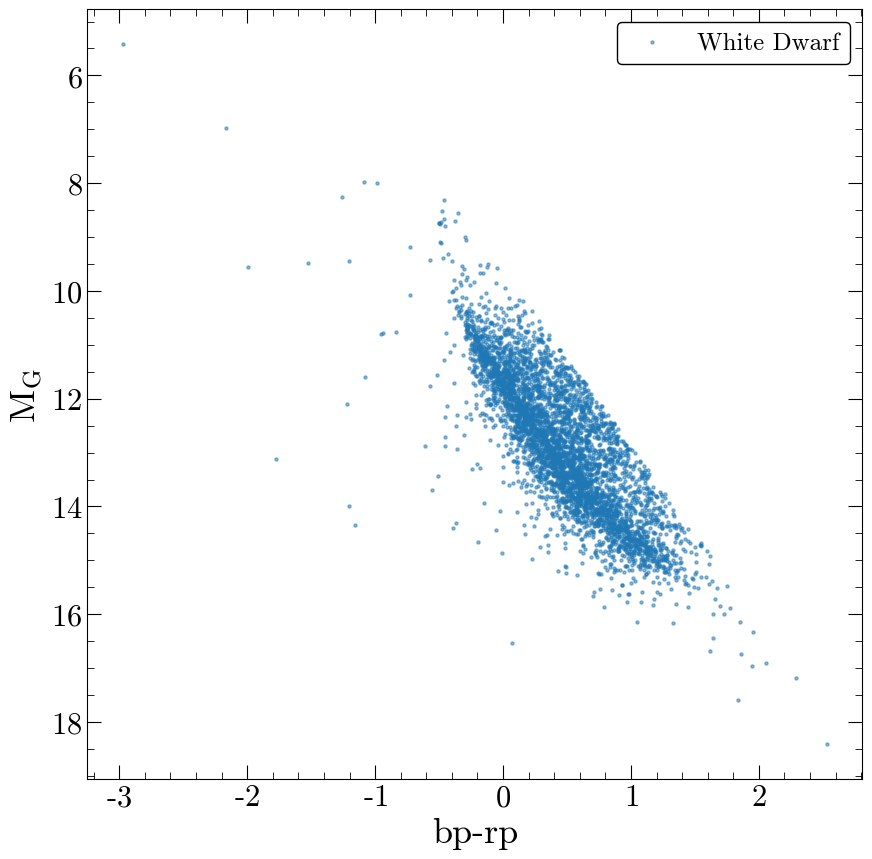

In [14]:
plt.figure(figsize=(10,10))
plt.style.use('./stefan.mplstyle')


plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)
#plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
#plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.legend()
plt.show()

In [12]:
catalog.remove_column('Unnamed: 0')
catalog = catalog[catalog['R_chance_align'] < 0.1]

print(len(catalog))

catalog['objnum'] = np.ones(len(catalog))
for i in range(len(catalog)):
    catalog['objnum'] = i
catalog.write('data/00_raw.fits', overwrite=True)

4490
